In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.pylab import cm
from scipy import stats

import cv2
from skimage import morphology

import json
from pprint import pprint
from cityscapes import *

In [2]:
#focal length from calibration files
fx = 2256.47
baseline = 0.209313

In [3]:
# load images
dataset_path = '/home/c276huan/bayesian-segmentation/models/deeplab/datasets/cityscapes'

img_path   = dataset_path + '/leftImg8bit/train/cologne/cologne_000008_000019_leftImg8bit.png'
seg_path   = img_path.replace('leftImg8bit.png', 'gtFine_color.png')\
                     .replace('leftImg8bit', 'gtFine')
annot_path = img_path.replace('leftImg8bit.png', 'gtFine_labelIds.png')\
                     .replace('leftImg8bit', 'gtFine')
disp_path  = img_path.replace('leftImg8bit', 'disparity')
bbox_path  = img_path.replace('leftImg8bit', 'gtBboxCityPersons')\
                     .replace('.png', '.json')

img   = cv2.imread(img_path)
seg   = cv2.imread(seg_path)
disp  = cv2.imread(disp_path,  cv2.IMREAD_UNCHANGED)
annot = cv2.imread(annot_path, cv2.IMREAD_UNCHANGED)
with open(bbox_path, 'r') as f:
    bbox = json.load(f)

#pprint([obj for obj in bbox['objects'] if obj['instanceId'] != 0])

In [4]:
disp = disp * ((disp != 0) & (disp / 100000 <= 0.222126))
disp[disp != 0]


array([    1,     1,     1, ...,  6970, 13116, 13116], dtype=uint16)

In [5]:
0.222126 * 2268.36 / 30

16.795391112

In [6]:
#convert disparity to depth
disp = (disp != 0) * ((disp.astype(np.float32)-1.) / 255.)
with np.errstate(divide='ignore'):
    depth = (baseline * fx) / disp
depth[disp == 0] = 0
# depth[annot == name2label['sky'].id] = np.Inf

#remove specks and fill in unknown values
# depth = cv2.medianBlur(depth, 5)
# depth = depth * morphology.remove_small_objects(depth != 0, min_size=1000, connectivity=2)
# depth = cv2.inpaint(depth.astype(np.float32), (disp == 0).astype(np.uint8), 3, cv2.INPAINT_NS)

In [7]:
depth.mean()

22.52509

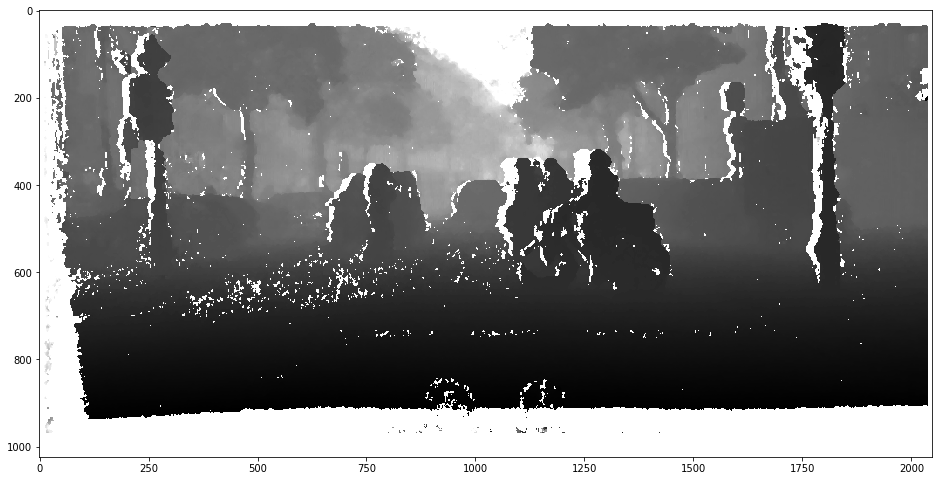

In [8]:
plt.figure(figsize=(16, 16))
ax = plt.subplot()
ax.imshow(np.ma.log(depth), cmap='gray')
# ax.imshow(seg, alpha=.1)
plt.show()

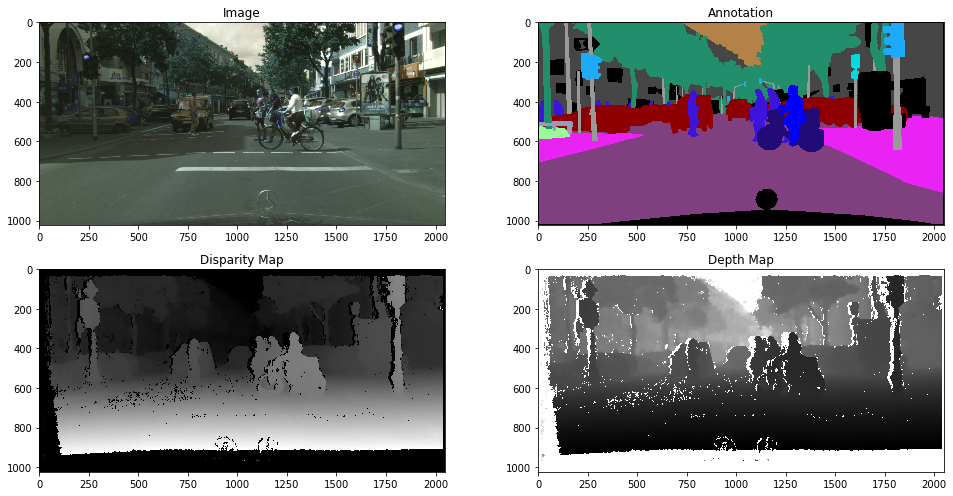

In [9]:
plt.figure(figsize=(14, 7))
plt.subplot(221)
plt.title('Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Annotation')
plt.imshow(seg)
plt.subplot(223)
plt.title('Disparity Map')
plt.imshow(disp, cmap='gray')
plt.subplot(224)
plt.title('Depth Map')
plt.imshow(np.ma.log(depth), cmap='gray')
plt.tight_layout()
plt.show()

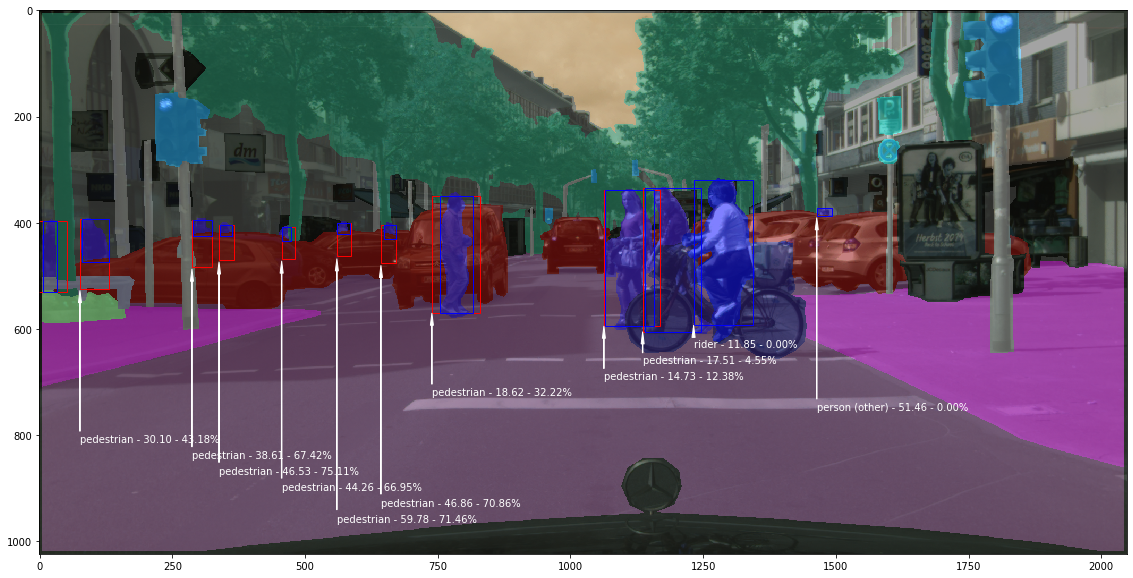

In [11]:
def t(d):
    d_max = np.max(d)
    d_min = np.min(d)
    return (d - d_min) / (d_max - d_min) * 1 # 255

plt.figure(figsize=(20,10))

ax = plt.subplot()
ax.imshow(img)
ax.imshow(seg, alpha=.5)
# ax.imshow(np.ma.log(depth), alpha=.75, cmap='gray')

for i, obj in enumerate(bbox['objects'], start=2):
    if obj['label'] == 'ignore':
        continue
    x, y, w, h = obj['bbox']
    x_vis, y_vis, w_vis, h_vis = obj['bboxVis']
    
    # Compute occlusion level
    occlusion = (1 - (w_vis*h_vis) / (w*h)) * 100
    
    # Get distance from depth map
    dist = np.array([])
    for u in range(y_vis, y_vis+h_vis):
        for v in range(x_vis, x_vis+w_vis):
            if (depth[u,v] >0 and id2label[annot[u, v]].category == 'human'):
                dist = np.append(dist, depth[u][v])
    
#     dist = dist[(np.abs(stats.zscore(dist)) < 1.96)]
    dist = dist.mean()
    # Annotate image
    label = f"{obj['label']} - {dist:.2f} - {occlusion:.2f}%"
    ax.annotate(label, (x, y+h), (x, img.shape[0] - i*30), color='white',
                arrowprops=dict(shrink=.01, width=.5, headwidth=3,
                                edgecolor='white', facecolor='white'))
    # Add bounding boxes
    ax.add_patch(
        Rectangle((x,y), w, h, linewidth=1, edgecolor='red', facecolor='none')
    )
    ax.add_patch(
        Rectangle((x_vis, y_vis), w_vis, h_vis, linewidth=1, edgecolor='blue', facecolor='none')
    )

plt.show()